# Optimizing 2 groups with only 1 observation: NoTransport model

Here we show how to optimize 2 functional groups with only 1 observation. As one of these groups is epipelagic and the other one is migrant-mesopelagic, we can use the epipelagic observation at night to optimize both groups.


In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit, KernelParameter
from seapopym.model import NoTransportLightModel

from seapopym_optimization.algorithm.genetic_algorithm.factory import GeneticAlgorithmFactory
from seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm import GeneticAlgorithmParameters
from seapopym_optimization.algorithm.genetic_algorithm.logbook import OptimizationLog
from seapopym_optimization.configuration_generator.no_transport_configuration_generator import (
    NoTransportConfigurationGenerator,
)
from seapopym_optimization.cost_function import TimeSeriesScoreProcessor
from seapopym_optimization.cost_function.cost_function import CostFunction
from seapopym_optimization.cost_function.metric import rmse_comparator
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.functional_group.base_functional_group import FunctionalGroupSet
from seapopym_optimization.functional_group.parameter_initialization import random_uniform_exclusive
from seapopym_optimization.observations.observation import DayCycle
from seapopym_optimization.observations.time_serie import TimeSeriesObservation


In [2]:
logging.basicConfig(level=logging.INFO, format="\n%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger("seapopym_optimization")
logger.setLevel(logging.INFO)

In [3]:
client = Client()
client

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51765 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51765/status,
Dashboard: http://127.0.0.1:51765/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51766,Workers: 0
Dashboard: http://127.0.0.1:51765/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:51777,Total threads: 3
Dashboard: http://127.0.0.1:51781/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51769,


## 1. Generate synthetic forcing data


In [4]:
nb_days_by_year = 365
nb_years = 20

# Temperature: sinusoidal pattern on 2 depth layers
# Layer 0: around 20°C, Layer 1: around 10°C
temperature_layer0 = np.sin(np.linspace(0, (2 * np.pi) * nb_years, nb_days_by_year * nb_years)) * 5 + 20
temperature_layer1 = np.sin(np.linspace(0, (2 * np.pi) * nb_years, nb_days_by_year * nb_years)) * 3 + 10

temperature = xr.DataArray(
    data=np.stack([temperature_layer0, temperature_layer1], axis=-1).reshape((nb_days_by_year * nb_years, 1, 1, 2)),
    dims=["time", "latitude", "longitude", "depth"],
    coords={
        "time": pd.date_range("2023-01-01", periods=nb_days_by_year * nb_years, freq="D"),
        "latitude": [0],
        "longitude": [0],
        "depth": [0, 1],
    },
    name="temperature",
    attrs={
        "units": "Celsius",
        "long_name": "Sea surface temperature",
        "standard_name": "sea_surface_temperature",
    },
)

# Primary production: random + cosine pattern
primary_production = xr.DataArray(
    data=(
        (
            np.random.rand(nb_days_by_year * nb_years).reshape((nb_days_by_year * nb_years, 1, 1))
            + (np.cos(np.linspace(0, np.pi * nb_years, nb_days_by_year * nb_years))).reshape(
                (nb_days_by_year * nb_years, 1, 1)
            )
        )
        + 2
    )
    / 100,
    dims=["time", "latitude", "longitude"],
    coords={
        "time": pd.date_range("2023-01-01", periods=nb_days_by_year * nb_years, freq="D"),
        "latitude": [0],
        "longitude": [0],
    },
    name="primary_production",
    attrs={
        "units": "kg/m^2/day",
        "long_name": "Primary production",
        "standard_name": "primary_production",
    },
)

# Set axis attributes
temperature.time.attrs = {"axis": "T"}
primary_production.time.attrs = {"axis": "T"}
temperature.latitude.attrs = {"axis": "Y"}
primary_production.latitude.attrs = {"axis": "Y"}
temperature.longitude.attrs = {"axis": "X", "unit": "degrees_east"}
primary_production.longitude.attrs = {"axis": "X"}
temperature.depth.attrs = {"axis": "Z"}

forcing_parameter = ForcingParameter(
    temperature=ForcingUnit(forcing=temperature),
    primary_production=ForcingUnit(forcing=primary_production),
)


2025-10-01 08:56:15,356 - seapopym.configuration.no_transport.forcing_parameter - INFO - Standardizing coordinates: {'time': 'T', 'latitude': 'Y', 'longitude': 'X', 'depth': 'Z'}

2025-10-01 08:56:15,367 - seapopym.configuration.no_transport.forcing_parameter - INFO - Standardizing coordinates: {'time': 'T', 'latitude': 'Y', 'longitude': 'X'}


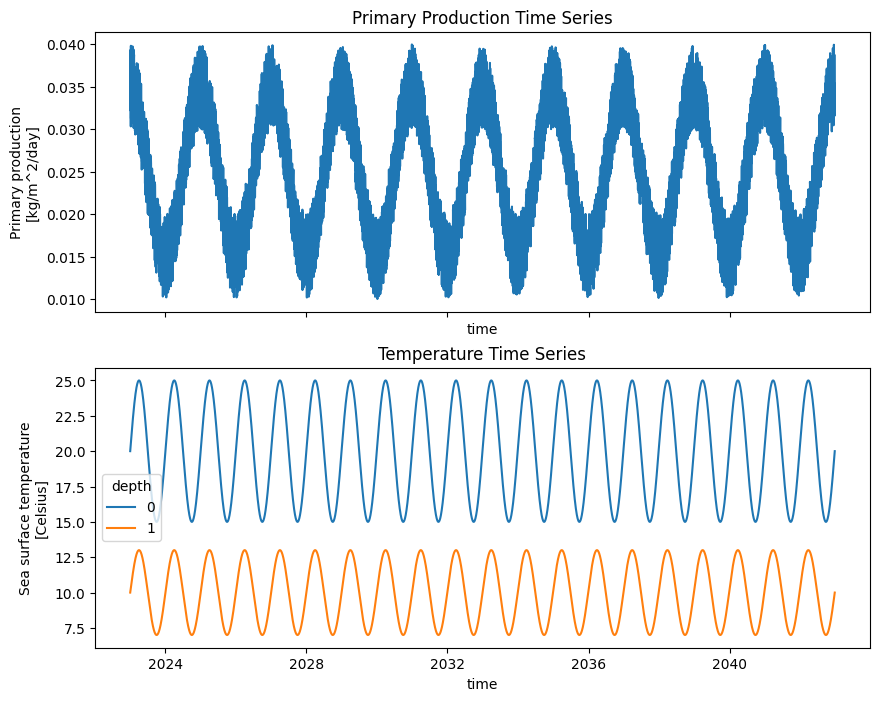

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
primary_production.plot(label="Primary Production", ax=ax1)
ax1.set_title("Primary Production Time Series")
temperature.plot(label="Temperature", ax=ax2, hue="depth")
ax2.set_title("Temperature Time Series")
plt.show()

## 2. Generate synthetic observations


In [6]:
epi_day_layer = 0
epi_night_layer = 1
meso_day_layer = 1
meso_night_layer = 0
energy_transfert_shared = 0.1668
tr_0_shared = 10.38
gamma_tr_shared = -0.11
lambda_temperature_shared = 0.15
gamma_lambda_temperature_shared = 1 / 150

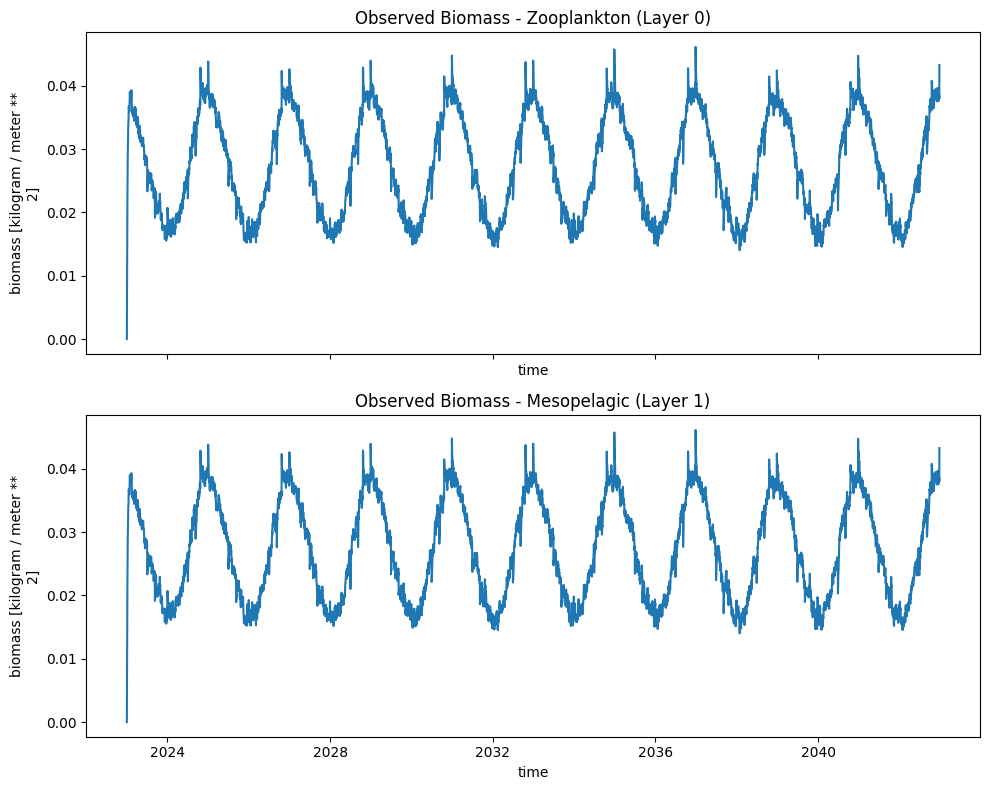

In [7]:
# Create a configuration generator
configuration_generator = NoTransportConfigurationGenerator(model_class=NoTransportLightModel)

# Run a model with known parameters to generate synthetic observations
# Group 1: Zooplankton in layer 0 (surface, ~20°C)
# Group 2: Mesopelagic in layer 1 (deeper, ~10°C)
initial_config = configuration_generator.generate(
    functional_group_parameters=[
        NoTransportFunctionalGroup(
            name="Zooplankton",
            day_layer=epi_day_layer,
            night_layer=epi_night_layer,
            energy_transfert=energy_transfert_shared,
            gamma_tr=gamma_tr_shared,
            tr_0=tr_0_shared,
            gamma_lambda_temperature=gamma_lambda_temperature_shared,
            lambda_temperature_0=lambda_temperature_shared,
        ),
        NoTransportFunctionalGroup(
            name="Mesopelagic",
            day_layer=meso_day_layer,
            night_layer=meso_night_layer,
            energy_transfert=energy_transfert_shared,
            gamma_tr=gamma_tr_shared,
            tr_0=tr_0_shared,
            gamma_lambda_temperature=gamma_lambda_temperature_shared,
            lambda_temperature_0=lambda_temperature_shared,
        ),
    ],
    forcing_parameters=forcing_parameter,
    kernel=KernelParameter(),
)

with NoTransportLightModel.from_configuration(initial_config) as initial_model:
    initial_model.run()
    observed_biomass = initial_model.state.biomass

# Prepare observation data for both groups
observed_biomass_group0 = (
    observed_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
)
observed_biomass_group0.layer.attrs = {"axis": "Z"}

observed_biomass_group1 = (
    observed_biomass.expand_dims({"layer": [1]}).isel(functional_group=1).drop_vars(["functional_group"])
)
observed_biomass_group1.layer.attrs = {"axis": "Z"}

# Plot both groups
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
observed_biomass_group0.plot(ax=ax1)
ax1.set_title("Observed Biomass - Zooplankton (Layer 0)")
observed_biomass_group1.plot(ax=ax2)
ax2.set_title("Observed Biomass - Mesopelagic (Layer 1)")
plt.tight_layout()

with xr.set_options(keep_attrs=True):
    night_observation = observed_biomass_group0 + observed_biomass_group1.data

# Create observation objects
observation_night = TimeSeriesObservation(
    name="Epipelagic at night",
    observation=night_observation,
    observation_type=DayCycle.NIGHT,
)

## 3. Define functional groups for optimization


In [8]:
epsilon = np.finfo(float).eps

shared_parameters = {
    "gamma_lambda_temperature": Parameter(
        "gamma_lambda_temperature", epsilon, 1 / 4, init_method=random_uniform_exclusive
    ),
    "lambda_temperature_0": Parameter("lambda_temperature_0", epsilon, 0.3, init_method=random_uniform_exclusive),
}

# Define 2 functional groups for optimization
functional_groups = [
    # Group 1: Zooplankton in layer 0
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("Zooplankton_energy_transfert", epsilon, 0.5, init_method=random_uniform_exclusive),
        gamma_tr=Parameter("Zooplankton_gamma_tr", -0.3, -epsilon, init_method=random_uniform_exclusive),
        tr_0=Parameter("Zooplankton_tr_0", epsilon, 100, init_method=random_uniform_exclusive),
        **shared_parameters,
    ),
    # Group 2: Mesopelagic in layer 1
    NoTransportFunctionalGroup(
        name="Mesopelagic",
        day_layer=1,
        night_layer=1,
        energy_transfert=Parameter("Mesopelagic_energy_transfert", epsilon, 0.5, init_method=random_uniform_exclusive),
        gamma_tr=Parameter("Mesopelagic_gamma_tr", -0.3, -epsilon, init_method=random_uniform_exclusive),
        tr_0=Parameter("Mesopelagic_tr_0", epsilon, 100, init_method=random_uniform_exclusive),
        **shared_parameters,
    ),
]

fg_set = FunctionalGroupSet(functional_groups=functional_groups)

## 4. Create cost function with processor


In [9]:
# Create processor with RMSE metric
processor = TimeSeriesScoreProcessor(comparator=rmse_comparator)

# Create cost function with both observations
cost_function = CostFunction(
    configuration_generator=configuration_generator,
    functional_groups=fg_set,
    forcing=forcing_parameter,
    kernel=KernelParameter(),
    observations=[observation_night],
    processor=processor,
)

## 5. Initialize logbook with Sobol samples


In [10]:
logbook = OptimizationLog.from_sobol_samples(fg_set, sample_number=64, fitness_names=["Epipelagic at night"])

## 6. Configure and run genetic algorithm


In [11]:
metaparam = GeneticAlgorithmParameters(
    ETA=20,
    INDPB=0.2,
    CXPB=0.7,
    MUTPB=1,
    NGEN=10,
    POP_SIZE=200,
    cost_function_weight=(-1,),  # Minimize RMSE for both groups
)

In [12]:
genetic_algorithm = GeneticAlgorithmFactory.create_distributed(
    meta_parameter=metaparam,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
)
genetic_algorithm


2025-10-01 08:56:19,196 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Creating genetic algorithm in distributed mode

2025-10-01 08:56:19,196 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing forcing to Dask workers with broadcast=True...

2025-10-01 08:56:21,083 - seapopym_optimization.algorithm.genetic_algorithm.factory - INFO - Distributing observation 'Epipelagic at night' to Dask workers with broadcast=True...


GeneticAlgorithm(meta_parameter=GeneticAlgorithmParameters(ETA=20, INDPB=0.2, CXPB=0.7, MUTPB=1, NGEN=10, POP_SIZE=200, TOURNSIZE=3, cost_function_weight=(np.float64(-1.0),)), cost_function=CostFunction(configuration_generator=NoTransportConfigurationGenerator(model_class=<class 'seapopym.model.no_transport_model.NoTransportLightModel'>), functional_groups=FunctionalGroupSet(functional_groups=[NoTransportFunctionalGroup(name='Zooplankton', day_layer=0, night_layer=0, energy_transfert=Parameter(name='Zooplankton_energy_transfert', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.5, init_method=<function random_uniform_exclusive at 0x11acfc0e0>), lambda_temperature_0=Parameter(name='lambda_temperature_0', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.3, init_method=<function random_uniform_exclusive at 0x11acfc0e0>), gamma_lambda_temperature=Parameter(name='gamma_lambda_temperature', lower_bound=np.float64(2.220446049250313e-16), upper_bound=0.25, init_method=<

# 7. Run optimization


In [13]:
optimization_results = genetic_algorithm.optimize()


2025-10-01 08:56:21,093 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - OptimizationLog found. Loading last generation.

2025-10-01 08:56:21,095 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - WARNING - Some individuals in the logbook have no fitness values. Re-evaluating the population.

2025-10-01 08:57:09,740 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 1 / 10.

2025-10-01 08:57:24,126 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 2 / 10.

2025-10-01 08:57:38,831 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 3 / 10.

2025-10-01 08:57:53,739 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 4 / 10.

2025-10-01 08:58:09,232 - seapopym_optimization.algorithm.genetic_algorithm.genetic_algorithm - INFO - Generation 5 / 10.

2025-10-01 08:58:24,206 - seapopym_opti

## 8. Plot results


Extract the best individual from the logbook


In [14]:
best_idx = optimization_results.dataset["weighted_fitness"].argmax(dim=["generation", "individual"])
best_individual = optimization_results.dataset.isel(best_idx)

parameters = dict(
    zip(
        list(best_individual.parameter.data),
        list(best_individual.parameters.data),
        strict=True,
    ),
)

print("Best fitness per objective:")
for obj_name, fitness_val in zip(best_individual.objective.data, best_individual.fitness.data, strict=True):
    print(f"  {obj_name}: {fitness_val:.6e}")

best_individual

Best fitness per objective:
  Epipelagic at night: 2.460725e-03


<xarray.Dataset> Size: 1kB
Dimensions:                      (parameter: 8, objective: 1)
Coordinates:
    individual                   int64 8B 175
  * parameter                    (parameter) <U28 896B 'Zooplankton_energy_tr...
  * objective                    (objective) <U19 76B 'Epipelagic at night'
    generation                   int64 8B 9
Data variables:
    parameters                   (parameter) float64 64B 0.3172 ... -0.1092
    fitness                      (objective) float64 8B 0.002461
    weighted_fitness_objectives  (objective) float64 8B -0.002461
    weighted_fitness             float64 8B -0.002461
    is_from_previous             float64 8B 0.0

Compute biomass with optimized parameters


In [15]:
# Create optimized functional groups with best parameters
optimized_fg_zooplankton = NoTransportFunctionalGroup(
    name="Zooplankton",
    day_layer=epi_day_layer,
    night_layer=epi_night_layer,
    energy_transfert=parameters["Zooplankton_energy_transfert"],
    gamma_tr=parameters["Zooplankton_gamma_tr"],
    tr_0=parameters["Zooplankton_tr_0"],
    gamma_lambda_temperature=parameters["gamma_lambda_temperature"],
    lambda_temperature_0=parameters["lambda_temperature_0"],
)

optimized_fg_mesopelagic = NoTransportFunctionalGroup(
    name="Mesopelagic",
    day_layer=meso_day_layer,
    night_layer=meso_night_layer,
    energy_transfert=parameters["Mesopelagic_energy_transfert"],
    gamma_tr=parameters["Mesopelagic_gamma_tr"],
    tr_0=parameters["Mesopelagic_tr_0"],
    gamma_lambda_temperature=parameters["gamma_lambda_temperature"],
    lambda_temperature_0=parameters["lambda_temperature_0"],
)

optimized_config = configuration_generator.generate(
    functional_group_parameters=[optimized_fg_zooplankton, optimized_fg_mesopelagic],
    forcing_parameters=forcing_parameter,
    kernel=KernelParameter(),
)

with NoTransportLightModel.from_configuration(optimized_config) as optimized_model:
    optimized_model.run()
    simulated_biomass = optimized_model.state.biomass

# Extract biomass for both functional groups
simulated_biomass_group0 = (
    simulated_biomass.expand_dims({"layer": [0]}).isel(functional_group=0).drop_vars(["functional_group"])
)
simulated_biomass_group0.layer.attrs = {"axis": "Z"}

simulated_biomass_group1 = (
    simulated_biomass.expand_dims({"layer": [1]}).isel(functional_group=1).drop_vars(["functional_group"])
)
simulated_biomass_group1.layer.attrs = {"axis": "Z"}

And plot comparison with observations


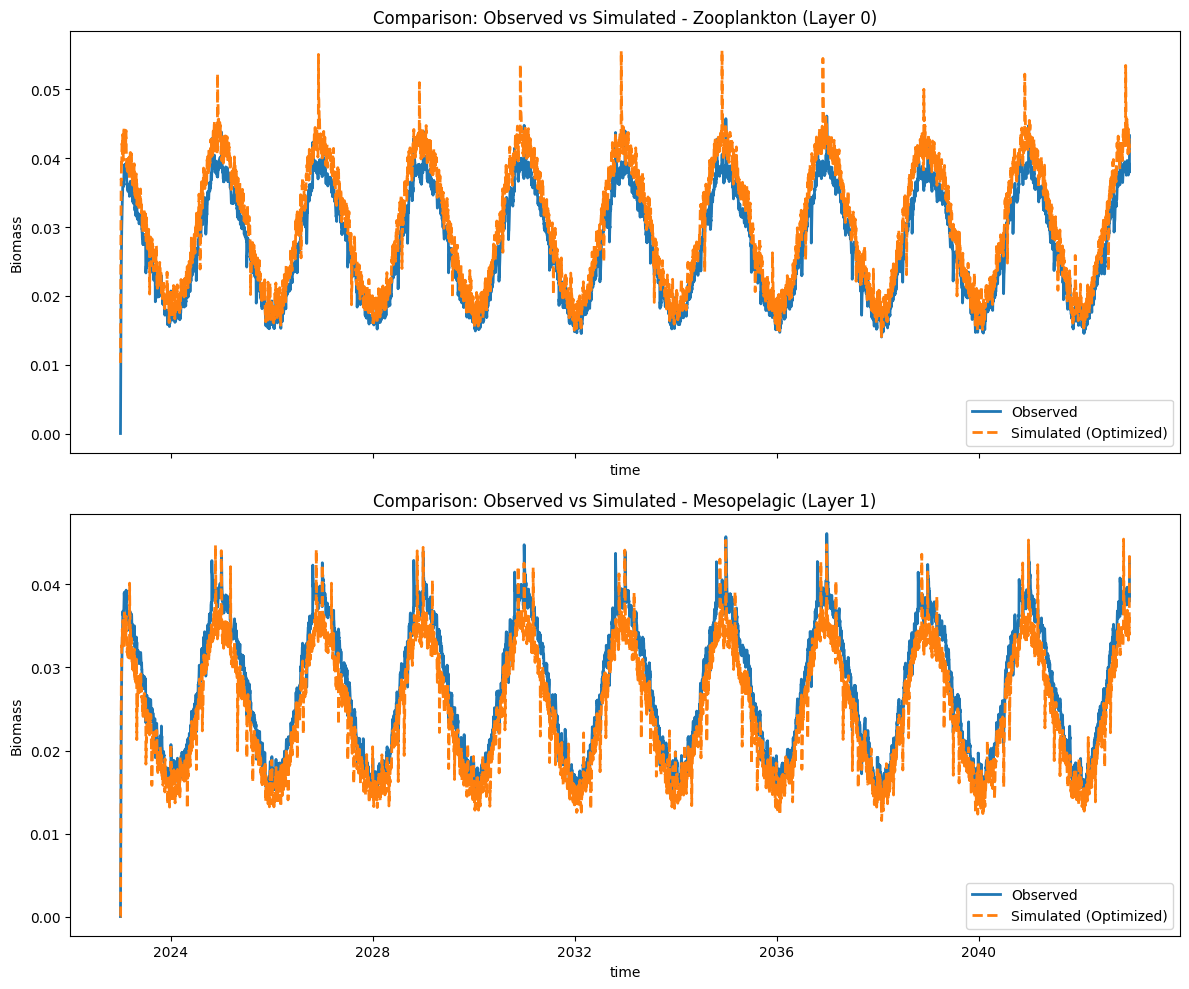

In [16]:
# Compare observed vs simulated biomass for both groups
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Group 0: Zooplankton
observed_biomass_group0.plot(label="Observed", ax=ax1, linewidth=2)
simulated_biomass_group0.plot(label="Simulated (Optimized)", ax=ax1, linewidth=2, linestyle="--")
ax1.set_title("Comparison: Observed vs Simulated - Zooplankton (Layer 0)")
ax1.set_ylabel("Biomass")
ax1.legend()

# Group 1: Mesopelagic
observed_biomass_group1.plot(label="Observed", ax=ax2, linewidth=2)
simulated_biomass_group1.plot(label="Simulated (Optimized)", ax=ax2, linewidth=2, linestyle="--")
ax2.set_title("Comparison: Observed vs Simulated - Mesopelagic (Layer 1)")
ax2.set_ylabel("Biomass")
ax2.legend()

plt.tight_layout()
plt.show()